# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Agistia Ronna Aniqa
- **Email:** agistiaronnaa@gmail.com
- **ID Dicoding:** MC299D5X1601

In [1]:
# Mengakses Google Drive dari Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Berpindah direktori kerja di Google Colab
%cd /content/drive/MyDrive/Proyek_KlasifikasiGambar

/content/drive/MyDrive/Proyek_KlasifikasiGambar


## Install PIP yang digunakan

In [3]:
# Menginstal berbagai library Python yang dibutuhkan
!pip install tensorflow tensorflowjs keras opendatasets pandas numpy matplotlib Pillow scipy scikit-learn seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


## Import Semua Packages/Library yang Digunakan

In [4]:
# Standard libraries untuk manipulasi file & folder, pengaturan path, dan struktur data tambahan
import os
from collections import defaultdict

import random
import shutil
import pathlib
import zipfile

# Image processing untuk memuat dan menampilkan gambar
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Data processing untuk manipulasi data, perhitungan numerik, dan visualisasi data
import pandas as pd
import numpy as np
import seaborn as sns

# TensorFlow and Keras untuk membangun model CNN, menambahkan layer-layer, training & validasi model, augmentasi gambar, menggunakan model pre-trained
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dropout, Dense, GlobalAveragePooling2D
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetV2B0, MobileNetV2

# External tools untuk mengunduh dataset dari situs seperti Kaggle secara langsung
import opendatasets as od

### Cek versi tensorflow yang digunakan

In [5]:
# Menampilkan versi TensorFlow yang sedang digunakan
print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 2.18.0


## Data Preparation

In [6]:
# Mengunduh dataset dari Kaggle menggunakan opendatasets
od.download(
    'https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset'
)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: agistiaronna
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset


In [7]:
# Mendapatkan daftar file dan folder dalam direktori
base_dir = '/content/drive/MyDrive/Proyek_KlasifikasiGambar/plantvillage-dataset/plantvillage dataset/color'
os.listdir(base_dir)

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [8]:
# Mengubah ukuran semua gambar dalam direktori ke ukuran acak antara min_size dan max_size
def resize_images_in_directory(base_path, min_size=200, max_size=256):
    for root, _, files in os.walk(base_path):
        for filename in files:
            path = os.path.join(root, filename)
            try:
                with Image.open(path) as img:
                    new_size = (
                        random.randint(min_size, max_size),
                        random.randint(min_size, max_size)
                    )
                    resized = img.resize(new_size, Image.Resampling.LANCZOS)
                    resized.save(path)
            except Exception as err:
                print(f"Gagal memproses {path}: {err}")

# Menganalisis dataset dengan menghitung jumlah gambar per kelas dan per resolusi gambar
def analyze_dataset(base_path, target_res=None):
    class_counts = {}
    resolution_counts = {}

    for root, _, files in os.walk(base_path):
        if root == base_path:
            continue

        class_name = os.path.basename(root)
        class_counts[class_name] = len(files)

        for filename in files:
            path = os.path.join(root, filename)
            try:
                with Image.open(path) as img:
                    res = f"{img.width}x{img.height}"
                    resolution_counts[res] = resolution_counts.get(res, 0) + 1

                    if target_res and res == target_res:
                        resolution_counts['target'] = resolution_counts.get('target', 0) + 1
            except Exception as err:
                print(f"Error membaca {path}: {err}")

    return class_counts, resolution_counts

# Menampilkan hasil analisis dari analyze_dataset dalam bentuk yang mudah dibaca
def display_analysis(class_counts, resolution_counts):
    print("\n Jumlah Gambar per Kelas:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count}")

    print("\n Jumlah Gambar per Resolusi:")
    for res, count in resolution_counts.items():
        label = "(target)" if res == 'target' else ""
        print(f"  {res}: {count} {label}")

In [9]:
dataset_path = '/content/drive/MyDrive/Proyek_KlasifikasiGambar/plantvillage-dataset/plantvillage dataset/color'
target_res = "256x256"

# Resize semua gambar untuk mengubah ukuran semua gambar di dalam direktori, dengan ukuran sisi acak antara 200 dan 256 piksel
resize_images_in_directory(dataset_path, min_size=200, max_size=256)

# Analisis dataset setelah resize untuk memeriksa dataset yang telah diubah ukurannya
class_counts, resolution_counts = analyze_dataset(dataset_path, target_res)

# Tampilkan hasil analisis dalam format yang mudah dibaca, yakni jumlah gambar per kelas dan per resolusi
display_analysis(class_counts, resolution_counts)


 Jumlah Gambar per Kelas:
  Apple___Apple_scab: 630
  Apple___Black_rot: 621
  Apple___Cedar_apple_rust: 275
  Apple___healthy: 1645
  Blueberry___healthy: 1502
  Cherry_(including_sour)___Powdery_mildew: 1052
  Cherry_(including_sour)___healthy: 854
  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513
  Corn_(maize)___Common_rust_: 1192
  Corn_(maize)___Northern_Leaf_Blight: 985
  Corn_(maize)___healthy: 1162
  Grape___Black_rot: 1180
  Grape___Esca_(Black_Measles): 1383
  Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076
  Grape___healthy: 423
  Orange___Haunglongbing_(Citrus_greening): 5507
  Peach___Bacterial_spot: 2297
  Peach___healthy: 360
  Pepper,_bell___Bacterial_spot: 997
  Pepper,_bell___healthy: 1478
  Potato___Early_blight: 1000
  Potato___Late_blight: 1000
  Potato___healthy: 152
  Raspberry___healthy: 371
  Soybean___healthy: 5090
  Squash___Powdery_mildew: 1835
  Strawberry___Leaf_scorch: 1109
  Strawberry___healthy: 456
  Tomato___Bacterial_spot: 2127
  Tomato___

In [10]:
# Menganalisis dataset berdasarkan kelas target dan menghitung jumlah gambar total serta jumlah gambar untuk subkelas dalam kelas target tersebut
def summarize_dataset_by_class(base_path, target="tomato"):
    total_images = 0
    target_images = 0
    subclass_distribution = {}

    for root, _, files in os.walk(base_path):
        image_count = len(files)
        total_images += image_count

        # Debugging: melacak folder yang sedang diproses selama iterasi
        print(f"Processing folder: {root}")

        # Cek apakah path folder mengandung nama kelas target (misalnya: tomato)
        if target.lower() in root.lower():
            target_images += image_count
            subclass = os.path.basename(root)
            subclass_distribution[subclass] = subclass_distribution.get(subclass, 0) + image_count

    return total_images, target_images, subclass_distribution

In [11]:
# Menganalisis jumlah gambar dalam dataset berdasarkan kelas target dan subkelasnya
# Inisialisasi path dan target kelas
dataset_dir = '/content/drive/MyDrive/Proyek_KlasifikasiGambar/plantvillage-dataset/plantvillage dataset/color'
target_class = "tomato"

# Analisis dataset
total, target_total, subclass_counts = summarize_dataset_by_class(dataset_dir, target_class)

# Tampilkan ringkasan hasil
# Menampilkan jumlah total gambar dalam dataset dan jumlah gambar yang berkaitan dengan kelas target ("tomato")
print(f" Total gambar di dataset: {total}")
print(f" Total gambar untuk kelas '{target_class}': {target_total}")

# Menampilkan rincian jumlah gambar untuk setiap subkelas dalam kelas target ("tomato")
print(f"\n Rincian jumlah gambar per subkelas dari '{target_class}':")
for subclass, count in subclass_counts.items():
    print(f"  - {subclass}: {count}")

Processing folder: /content/drive/MyDrive/Proyek_KlasifikasiGambar/plantvillage-dataset/plantvillage dataset/color
Processing folder: /content/drive/MyDrive/Proyek_KlasifikasiGambar/plantvillage-dataset/plantvillage dataset/color/Apple___Apple_scab
Processing folder: /content/drive/MyDrive/Proyek_KlasifikasiGambar/plantvillage-dataset/plantvillage dataset/color/Apple___Black_rot
Processing folder: /content/drive/MyDrive/Proyek_KlasifikasiGambar/plantvillage-dataset/plantvillage dataset/color/Apple___Cedar_apple_rust
Processing folder: /content/drive/MyDrive/Proyek_KlasifikasiGambar/plantvillage-dataset/plantvillage dataset/color/Apple___healthy
Processing folder: /content/drive/MyDrive/Proyek_KlasifikasiGambar/plantvillage-dataset/plantvillage dataset/color/Blueberry___healthy
Processing folder: /content/drive/MyDrive/Proyek_KlasifikasiGambar/plantvillage-dataset/plantvillage dataset/color/Cherry_(including_sour)___Powdery_mildew
Processing folder: /content/drive/MyDrive/Proyek_Klasifi

In [12]:
# Menyalin seluruh folder yang mengandung kata kunci tertentu dari direktori sumber ke direktori tujuan
def extract_target_folders(source_dir, output_dir="dataset", keyword="tomato"):
    os.makedirs(output_dir, exist_ok=True)

    for current_root, folders, _ in os.walk(source_dir):
        for folder in folders:
            if keyword.lower() in folder.lower():
                source_path = os.path.join(current_root, folder)
                target_path = os.path.join(output_dir, folder)

                if not os.path.exists(target_path):
                    shutil.copytree(source_path, target_path)
                    print(f" Disalin: {source_path} → {target_path}")
                else:
                    print(f" Dilewati (sudah ada): {target_path}")

# Menghapus awalan tertentu dari nama folder di dalam direktori yang ditentukan
def clean_folder_names(target_dir, strip_prefix="Tomato___"):
    for folder_name in os.listdir(target_dir):
        if folder_name.startswith(strip_prefix):
            old_path = os.path.join(target_dir, folder_name)
            new_name = folder_name[len(strip_prefix):]
            new_path = os.path.join(target_dir, new_name)

            os.rename(old_path, new_path)
            print(f" Diubah: {old_path} → {new_path}")

In [13]:
# Langkah Pipeline
# Menyiapkan dataset khusus untuk kelas "tomato" dari dataset utama, dengan nama folder yang sudah dirapikan agar lebih mudah digunakan dalam proses pelatihan model
if __name__ == "__main__":
    dataset_source = '/content/drive/MyDrive/Proyek_KlasifikasiGambar/plantvillage-dataset/plantvillage dataset/color'
    tomato_dataset_target = "/content/drive/MyDrive/Proyek_KlasifikasiGambar/main_dataset"

    # Salin folder bertema 'tomato'
    extract_target_folders(dataset_source, tomato_dataset_target, keyword="tomato")

    # Rapikan nama folder
    clean_folder_names(tomato_dataset_target, strip_prefix="Tomato___")

 Disalin: /content/drive/MyDrive/Proyek_KlasifikasiGambar/plantvillage-dataset/plantvillage dataset/color/Tomato___Bacterial_spot → /content/drive/MyDrive/Proyek_KlasifikasiGambar/main_dataset/Tomato___Bacterial_spot
 Disalin: /content/drive/MyDrive/Proyek_KlasifikasiGambar/plantvillage-dataset/plantvillage dataset/color/Tomato___Early_blight → /content/drive/MyDrive/Proyek_KlasifikasiGambar/main_dataset/Tomato___Early_blight
 Disalin: /content/drive/MyDrive/Proyek_KlasifikasiGambar/plantvillage-dataset/plantvillage dataset/color/Tomato___Late_blight → /content/drive/MyDrive/Proyek_KlasifikasiGambar/main_dataset/Tomato___Late_blight
 Disalin: /content/drive/MyDrive/Proyek_KlasifikasiGambar/plantvillage-dataset/plantvillage dataset/color/Tomato___Leaf_Mold → /content/drive/MyDrive/Proyek_KlasifikasiGambar/main_dataset/Tomato___Leaf_Mold
 Disalin: /content/drive/MyDrive/Proyek_KlasifikasiGambar/plantvillage-dataset/plantvillage dataset/color/Tomato___Septoria_leaf_spot → /content/drive/M

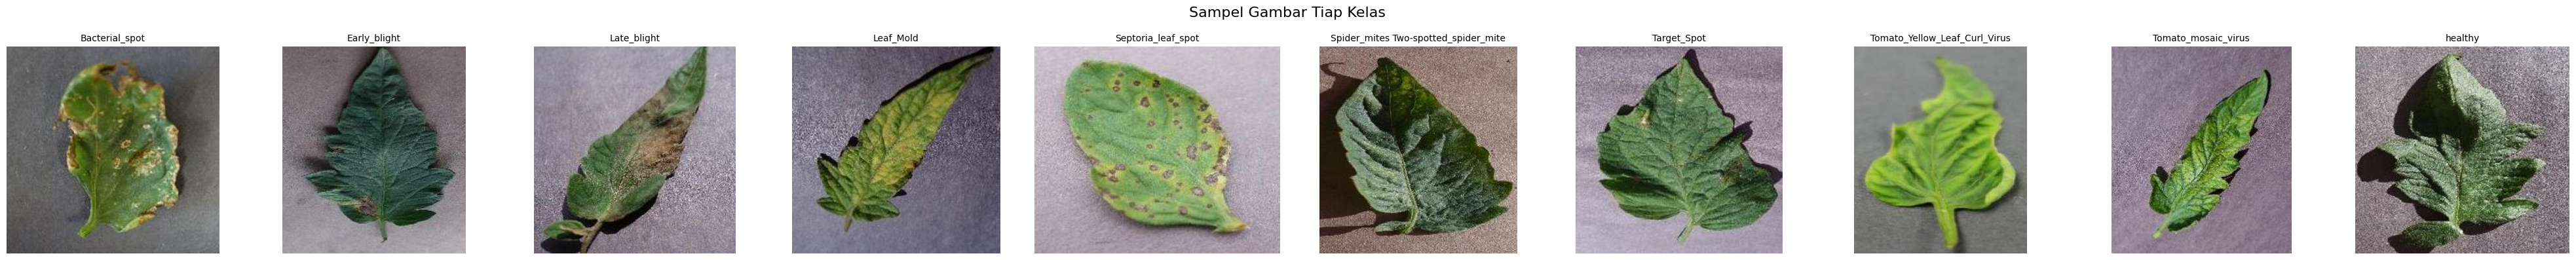

In [14]:
# Menampilkan satu contoh gambar dari setiap kelas (berdasarkan nama folder) dalam dataset
def show_example_image(dataset_path):
    gambar_kelas = {}

    # Telusuri struktur folder dataset dengan ambil satu gambar acak dari tiap folder
    for folder_utama, _, daftar_berkas in os.walk(dataset_path):
        if daftar_berkas:
            nama_kelas = os.path.basename(folder_utama)
            contoh = random.choice(daftar_berkas)
            gambar_kelas[nama_kelas] = os.path.join(folder_utama, contoh)

    # Menampilkan gambar
    jumlah_kelas = len(gambar_kelas)
    ukuran_fig = (4 * jumlah_kelas, 4)
    fig, axes = plt.subplots(1, jumlah_kelas, figsize=ukuran_fig)
    fig.suptitle("Sampel Gambar Tiap Kelas", fontsize=16)

    if jumlah_kelas == 1:
        axes = [axes]

    for ax, (label, path) in zip(axes, gambar_kelas.items()):
        with Image.open(path) as img:
            ax.imshow(img)
        ax.set_title(label, fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Panggil fungsi langsung
show_example_image("/content/drive/MyDrive/Proyek_KlasifikasiGambar/main_dataset")

In [15]:
# Menghapus semua folder yang tidak termasuk dalam daftar keep_folders dari direktori dataset
def delete_unwanted_folders(base_path, keep_folders=None):
    if keep_folders is None:
        keep_folders = ['Tomato_Yellow_Leaf_Curl_Virus', 'Late_blight', 'healthy', 'Septoria_leaf_spot']

    # Mengecek semua item (folder atau file) di dalam base_path
    for item in os.listdir(base_path):
        item_path = os.path.join(base_path, item)

        # Jika item merupakan folder dan bukan termasuk folder yang ingin disimpan, maka akan dihapus
        if os.path.isdir(item_path) and item not in keep_folders:
            shutil.rmtree(item_path)  # Menghapus folder
            print(f"Menghapus folder: {item_path}")

# Path ke folder utama
base_path = "/content/drive/MyDrive/Proyek_KlasifikasiGambar/main_dataset"

# Menjalankan fungsi untuk menghapus folder yang tidak diinginkan
delete_unwanted_folders(base_path)

Menghapus folder: /content/drive/MyDrive/Proyek_KlasifikasiGambar/main_dataset/Bacterial_spot
Menghapus folder: /content/drive/MyDrive/Proyek_KlasifikasiGambar/main_dataset/Early_blight
Menghapus folder: /content/drive/MyDrive/Proyek_KlasifikasiGambar/main_dataset/Leaf_Mold
Menghapus folder: /content/drive/MyDrive/Proyek_KlasifikasiGambar/main_dataset/Spider_mites Two-spotted_spider_mite
Menghapus folder: /content/drive/MyDrive/Proyek_KlasifikasiGambar/main_dataset/Target_Spot
Menghapus folder: /content/drive/MyDrive/Proyek_KlasifikasiGambar/main_dataset/Tomato_mosaic_virus


### Split Dataset

In [16]:
# Membagi dataset gambar ke dalam folder train dan test sesuai rasio tertentu (default 80% train, 20% test).
def split_dataset(base_path, train_ratio=0.8):
    train_path = os.path.join(base_path, 'train')
    test_path = os.path.join(base_path, 'test')

    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    # Telusuri folder kelas
    for root, dirs, files in os.walk(base_path):
        if root == base_path or os.path.basename(root) in ['train', 'test']:
            continue

        # Buat subfolder untuk setiap kelas di train/test
        class_name = os.path.basename(root)
        train_class_path = os.path.join(train_path, class_name)
        test_class_path = os.path.join(test_path, class_name)
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        # Pisahkan dan pindahkan file
        random.shuffle(files)
        split_index = int(train_ratio * len(files))
        train_files = files[:split_index]
        test_files = files[split_index:]

        for file in train_files:
            src_file = os.path.join(root, file)
            dst_file = os.path.join(train_class_path, file)
            shutil.move(src_file, dst_file)

        for file in test_files:
            src_file = os.path.join(root, file)
            dst_file = os.path.join(test_class_path, file)
            shutil.move(src_file, dst_file)

# Set path ke dataset utama
base_path = "/content/drive/MyDrive/Proyek_KlasifikasiGambar/main_dataset"

# Bagi dataset menjadi train/test
split_dataset(base_path)

In [17]:
# Menghapus semua folder selain train dan test dari direktori utama dataset setelah proses split selesai
def delete_unwanted_folders(base_path, keep_folders=['train', 'test']):
    for item in os.listdir(base_path):
        item_path = os.path.join(base_path, item)
        if os.path.isdir(item_path) and item not in keep_folders:
            shutil.rmtree(item_path)
            print(f"Menghapus folder: {item_path}")

# Path ke folder utama
base_path = "/content/drive/MyDrive/Proyek_KlasifikasiGambar/main_dataset"

delete_unwanted_folders(base_path)

Menghapus folder: /content/drive/MyDrive/Proyek_KlasifikasiGambar/main_dataset/Late_blight
Menghapus folder: /content/drive/MyDrive/Proyek_KlasifikasiGambar/main_dataset/Septoria_leaf_spot
Menghapus folder: /content/drive/MyDrive/Proyek_KlasifikasiGambar/main_dataset/Tomato_Yellow_Leaf_Curl_Virus
Menghapus folder: /content/drive/MyDrive/Proyek_KlasifikasiGambar/main_dataset/healthy


# Modelling

### Augmentasi dan Load Dataset (Train, Validation, Test)

In [18]:
# Menyiapkan dataset citra dengan augmentasi, resize, dan membagi menjadi train, validation, dan test secara otomatis menggunakan ImageDataGenerator
def augment_and_resize_dataset(base_path, img_size=(150, 150), batch_size=32):
    train_path = os.path.join(base_path, 'train')
    test_path = os.path.join(base_path, 'test')

    # Data Augmentation untuk training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2  # Membagi validation set dari train set
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    # Mengambil gambar dari folder train dan membaginya menjadi data training dan validasi
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'  # Data pelatihan
    )

    validation_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'  # Data validasi
    )

    # Generator untuk test (tanpa augmentasi)
    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, validation_generator, test_generator

# Set path ke dataset utama
base_path = "/content/drive/MyDrive/Proyek_KlasifikasiGambar/main_dataset"

# Augmentasi dan pembagian train/val/test
train_generator, val_generator, test_generator = augment_and_resize_dataset(base_path)

Found 7890 images belonging to 4 classes.
Found 1971 images belonging to 4 classes.
Found 767 images belonging to 4 classes.


In [19]:
# Menampilkan indeks numerik dari masing-masing kelas (label) yang dikenali oleh train_generator setelah data diproses oleh ImageDataGenerator
class_indices = train_generator.class_indices
print(class_indices)

{'Late_blight': 0, 'Septoria_leaf_spot': 1, 'Tomato_Yellow_Leaf_Curl_Virus': 2, 'healthy': 3}


### Membangun dan Melatih Model

In [20]:
# Membangun dan melatih model klasifikasi gambar menggunakan transfer learning dari MobileNetV2, dengan lapisan tambahan untuk menyesuaikan dengan dataset tomat
def build_and_train_model(train_generator, val_generator, num_epochs=10):
    # Memuat model pralatih MobileNetV2 tanpa lapisan top (fully connected layers)
    pre_trained_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

    # Menonaktifkan pelatihan untuk layer-layer pralatih
    for layer in pre_trained_model.layers:
        layer.trainable = False

    # Membuat model baru dengan arsitektur Sequential
    model = Sequential([
        pre_trained_model,  # Menambahkan model pralatih
        Conv2D(32, (3, 3), activation='relu', padding='same'),  # Lapisan konvolusi pertama
        MaxPooling2D((2, 2)),  # Lapisan pooling
        Conv2D(64, (3, 3), activation='relu', padding='same'),  # Lapisan konvolusi kedua
        MaxPooling2D((2, 2)),  # Lapisan pooling
        Flatten(name="flatten"),  # Mengubah output 2D menjadi 1D
        Dropout(0.5),  # Dropout untuk mengurangi overfitting
        Dense(128, activation="relu"),  # Lapisan Dense untuk klasifikasi
        Dense(train_generator.num_classes, activation='softmax')  # Output layer dengan softmax
    ])

    # Menyusun model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),  # Optimizer Adam
        loss='categorical_crossentropy',  # Fungsi loss untuk klasifikasi multi-kelas
        metrics=['accuracy']  # Menghitung akurasi selama pelatihan
    )

    # Inisialisasi callback untuk menyimpan model terbaik berdasarkan val_loss
    checkpoint = ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    )

    # Early stopping untuk menghentikan pelatihan jika tidak ada perbaikan pada validasi
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=3,  # Berhenti jika tidak ada peningkatan dalam 3 epoch
        restore_best_weights=True,
        mode='max'  # Mode untuk meningkatkan akurasi validasi
    )

    # Melatih model dengan data pelatihan dan validasi
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=num_epochs,
        callbacks=[checkpoint, early_stopping],  # Menggunakan callback
        verbose=1  # Menampilkan log pelatihan
    )

    # Mengembalikan model dan history pelatihan
    return model, history


# Misalkan sudah ada train_generator dan validation_generator dari dataset
model, history = build_and_train_model(train_generator, val_generator, num_epochs=10)

<ipython-input-20-d81c3af4908f>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre_trained_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(150, 150, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.7947 - loss: 0.5188 - val_accuracy: 0.9564 - val_loss: 0.1307
Epoch 2/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.9505 - loss: 0.1495 - val_accuracy: 0.9731 - val_loss: 0.0862
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 279s 1s/step - accuracy: 0.9736 - loss: 0.0861 - val_accuracy: 0.9716 - val_loss: 0.0897
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.9798 - loss: 0.0719 - val_accuracy: 0.9645 - val_loss: 0.1040
Epoch 5/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 306s 1s/step - accuracy: 0.9765 - loss: 0.0741 - val_accuracy: 0.9777 - val_loss: 0.0671
Epoch 6/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.9776 - loss: 0.0737 - val_accuracy: 0.9812 - val_loss: 0.0589
Epoch 7/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.9856 - loss: 0.0482 - val_accuracy: 0.9838 - val_loss: 0.0585
Epoch 8/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.9805 - loss: 0.0697 - val_accu

In [21]:
# Menampilkan arsitektur lengkap dari model deep learning yang telah dibangun
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 5, 5, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 2, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,445,998 (13.15 MB)

 Trainable params: 396,004 (1.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 792,010 (3.02 MB)

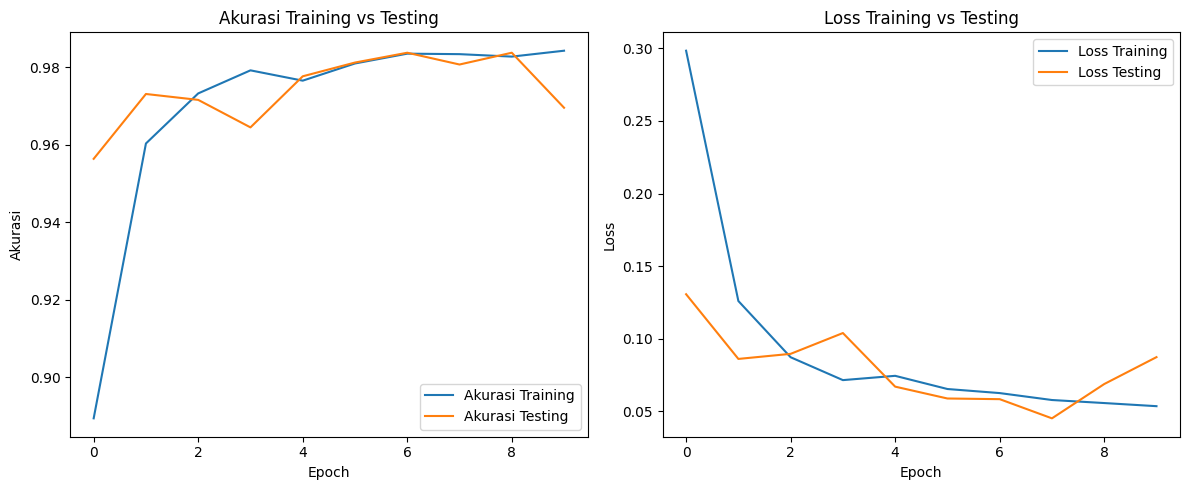

In [22]:
# Menampilkan grafik performa model selama pelatihan, khususnya akurasi dan loss, baik untuk data training maupun data validasi/testing
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Testing')
plt.title('Akurasi Training vs Testing')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Testing')
plt.title('Loss Training vs Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 779ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 677ms/step - accuracy: 0.9881 - loss: 0.0466

Akurasi Pengujian (Testing): 0.9791
Akurasi Akhir Training     : 0.9843
Akurasi Akhir Validasi     : 0.9696


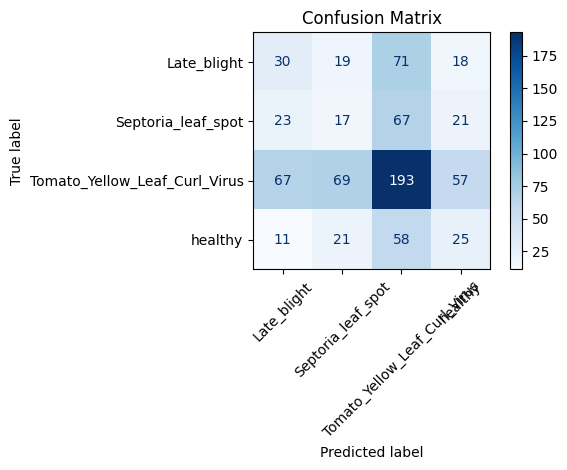

In [23]:
# Evaluasi akhir performa model klasifikasi dengan beberapa metrik penting dan visualisasi
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Melakukan prediksi pada test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Label asli
y_true = test_generator.classes

# Evaluasi model pada data testing
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nAkurasi Pengujian (Testing): {test_acc:.4f}")

# Ambil akurasi terakhir dari training dan validasi
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

# Tampilkan akurasi training, validasi, dan testing
print(f"Akurasi Akhir Training     : {final_train_acc:.4f}")
print(f"Akurasi Akhir Validasi     : {final_val_acc:.4f}")

# Hitung Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Mendapatkan label kelas
class_labels = list(test_generator.class_indices.keys())

# Tampilkan Confusion Matrix dalam bentuk grafik
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## Menyimpan Model

In [24]:
# Menyimpan model yang telah dilatih (termasuk arsitektur, bobot, dan konfigurasi training) ke dalam file bernama model.h5 dengan format HDF5
model.save("model.h5")

In [25]:
# Mengonversi model Keras (model.h5) ke format TensorFlow.js, sehingga bisa dijalankan di browser atau aplikasi JavaScript
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2025-04-26 11:15:51.461090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745666151.843540   39303 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745666151.948921   39303 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [26]:
# Menyimpan model dalam format SavedModel, format standar TensorFlow yang lebih fleksibel daripada .h5
save_path = os.path.join("saved_model")
tf.saved_model.save(model, save_path)

In [27]:
# Mengonversi model .h5 menjadi TensorFlow Lite (.tflite) untuk keperluan deployment ke perangkat mobile atau edge device, dan menyimpan label klasifikasi
# Buat folder simpan model
folder_path = "./tflite_model"
os.makedirs(folder_path, exist_ok=True)

# Memuat model Keras yang sebelumnya sudah dilatih
model_TFLITE = tf.keras.models.load_model('model.h5')

# Konversi model ke format .tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model_TFLITE)
tflite_model = converter.convert()

# Menyimpan model ke file .tflite.
tflite_path = os.path.join(folder_path, "model.tflite")
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

# Buat file label klasifikasi
label_content = """Late_blight
Septoria_leaf_spot
Tomato_Yellow_Leaf_Curl_Virus
healthy"""

label_path = os.path.join(folder_path, "label.txt")
with open(label_path, "w") as file:
    file.write(label_content)

print(f"Model TFLite dan label berhasil disimpan di: {folder_path}")

Saved artifact at '/tmp/tmpgu5938u6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136120067292240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136120067290320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136120067289168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136120067290704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136120067291856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136120067288784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136120067289360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136120067286864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136120067290512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136120067291280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1361200672874

In [28]:
# Menyimpan daftar semua library dan versinya yang terinstall saat ini ke dalam file requirements.txt
!pip freeze > requirements.txt

# Inference

Model expects input shape: [  1 150 150   3]

Silakan upload gambar daun tomat...


Saving 0ea612c0-8416-4771-a8bb-d5d255800f94___JR_Sept.L.S 8533.JPG to 0ea612c0-8416-4771-a8bb-d5d255800f94___JR_Sept.L.S 8533.JPG

Memproses: 0ea612c0-8416-4771-a8bb-d5d255800f94___JR_Sept.L.S 8533.JPG


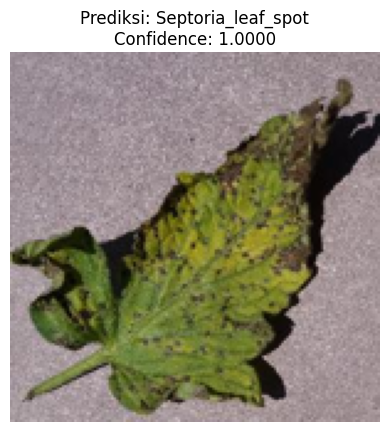

Ketik 'lanjut' untuk upload lagi, atau apa pun untuk selesai: lanjut

Silakan upload gambar daun tomat...


Saving 0a6203b9-ced0-4934-ae23-4a7d2e2e2fdd___RS_Late.B 6424.JPG to 0a6203b9-ced0-4934-ae23-4a7d2e2e2fdd___RS_Late.B 6424.JPG

Memproses: 0a6203b9-ced0-4934-ae23-4a7d2e2e2fdd___RS_Late.B 6424.JPG


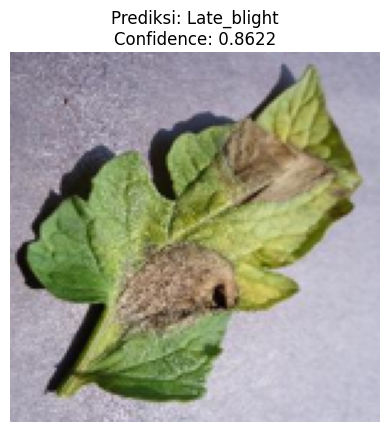

Ketik 'lanjut' untuk upload lagi, atau apa pun untuk selesai: lanjut

Silakan upload gambar daun tomat...


Saving 0c9f5882-6af4-4472-8504-0987cdb4048a___UF.GRC_YLCV_Lab 01610.JPG to 0c9f5882-6af4-4472-8504-0987cdb4048a___UF.GRC_YLCV_Lab 01610.JPG

Memproses: 0c9f5882-6af4-4472-8504-0987cdb4048a___UF.GRC_YLCV_Lab 01610.JPG


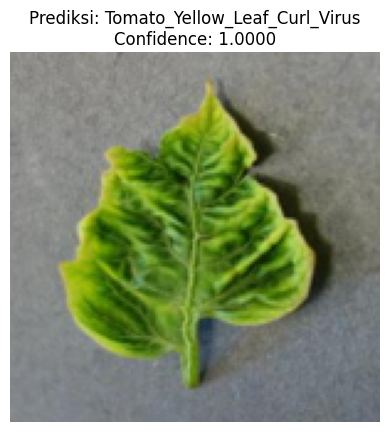

Ketik 'lanjut' untuk upload lagi, atau apa pun untuk selesai: lanjut

Silakan upload gambar daun tomat...


Saving 3f1ce663-3715-4220-bbce-93bcc9f0c478___GH_HL Leaf 311.JPG to 3f1ce663-3715-4220-bbce-93bcc9f0c478___GH_HL Leaf 311.JPG

Memproses: 3f1ce663-3715-4220-bbce-93bcc9f0c478___GH_HL Leaf 311.JPG


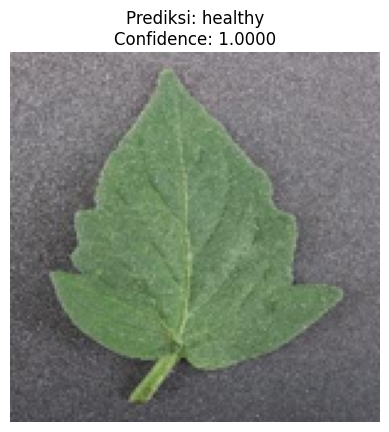

Ketik 'lanjut' untuk upload lagi, atau apa pun untuk selesai: selesai
Inference selesai.


In [29]:
# Melakukan inferensi/prediksi pada gambar daun tomat menggunakan model TensorFlow Lite (.tflite) yang sudah dilatih sebelumnya
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import os

# Memuat model .tflite ke dalam interpreter untuk siap digunakan prediksi
interpreter = tf.lite.Interpreter(model_path="./tflite_model/model.tflite")
interpreter.allocate_tensors()

# Dapatkan info input/output dari model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Model expects input shape:", input_details[0]['shape'])

# Load Label Kelas
with open("./tflite_model/label.txt", "r") as file:
    class_labels = [line.strip() for line in file.readlines()]

# Fungsi preprocessing gambar
def preprocess_image(image_path, target_size=(150, 150)):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size)
    image_array = np.array(image, dtype=np.float32) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    return image_array, image

# Fungsi prediksi
def predict_image(image_path):
    input_data, original_img = preprocess_image(image_path)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_index = np.argmax(output_data)
    predicted_label = class_labels[predicted_index]
    confidence = float(np.max(output_data))

    plt.imshow(original_img)
    plt.axis('off')
    plt.title(f"Prediksi: {predicted_label}\nConfidence: {confidence:.4f}", fontsize=12)
    plt.show()

# Loop Upload dan prediksi
while True:
    print("\nSilakan upload gambar daun tomat...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\nMemproses: {filename}")
        predict_image(filename)

    lanjut = input("Ketik 'lanjut' untuk upload lagi, atau apa pun untuk selesai: ").lower()
    if lanjut != 'lanjut':
        print("Inference selesai.")
        break